In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import t
import seaborn as sns



In [4]:
# Load data
data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

# Convert 'User_Score' to numeric and coerce errors to NaN
data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

# Check for NaN values and handle them by dropping rows with NaN values
print("NaN values before cleaning:")
print(data[['User_Score', 'Critic_Score', 'Global_Sales']].isnull().sum())
data.dropna(subset=['User_Score', 'Critic_Score', 'Global_Sales'], inplace=True)

NaN values before cleaning:
User_Score      9129
Critic_Score    8582
Global_Sales       0
dtype: int64


In [5]:
#Statistics
# Select numerical sales columns for analysis
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Use describe to get basic statistics
basic_stats = data[sales_columns].describe()

# Calculate skewness and kurtosis
skewness = data[sales_columns].skew().rename('skew')
kurtosis = data[sales_columns].kurt().rename('kurt')

# Generate a correlation matrix
correlation_matrix = data[sales_columns].corr()

# Print the results
print("Basic Statistics:\n", basic_stats)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)
print("\nCorrelation Matrix:\n", correlation_matrix)

Basic Statistics:
           NA_Sales     EU_Sales     JP_Sales  Other_Sales  Global_Sales
count  7017.000000  7017.000000  7017.000000  7017.000000   7017.000000
mean      0.389290     0.233095     0.062951     0.081525      0.767049
std       0.957051     0.679210     0.284162     0.266594      1.940317
min       0.000000     0.000000     0.000000     0.000000      0.010000
25%       0.060000     0.020000     0.000000     0.010000      0.110000
50%       0.150000     0.060000     0.000000     0.020000      0.290000
75%       0.390000     0.210000     0.010000     0.070000      0.750000
max      41.360000    28.960000     6.500000    10.570000     82.530000

Skewness:
 NA_Sales        16.292784
EU_Sales        16.271002
JP_Sales        10.668705
Other_Sales     19.191336
Global_Sales    16.238988
Name: skew, dtype: float64

Kurtosis:
 NA_Sales        533.274602
EU_Sales        516.528202
JP_Sales        152.041164
Other_Sales     590.255928
Global_Sales    512.993168
Name: kurt, dtype

C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\clust

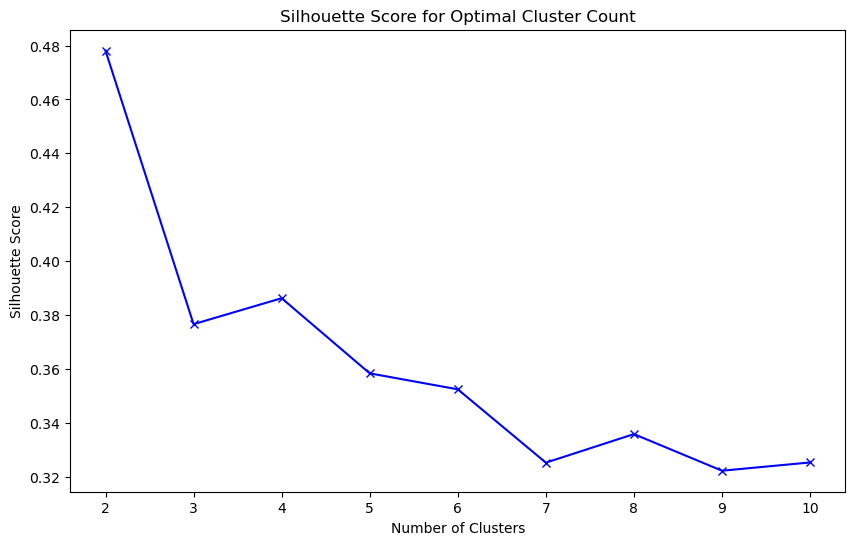

C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


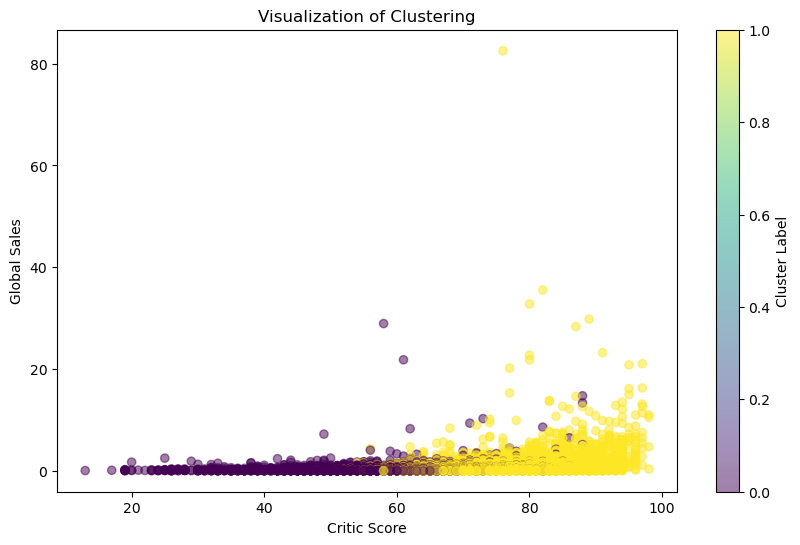

In [6]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['User_Score', 'Critic_Score', 'Global_Sales']])

# Determine the optimal number of clusters
range_n_clusters = list(range(2, 11))  
silhouette_avg = [silhouette_score(data_scaled, KMeans(n_clusters=n, random_state=10).fit_predict(data_scaled)) for n in range_n_clusters]
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]

#plot the silhoutte scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Cluster Count')
plt.show()

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

data['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
plt.scatter(data['Critic_Score'], data['Global_Sales'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Critic Score')
plt.ylabel('Global Sales')
plt.title('Visualization of Clustering')
plt.colorbar(label='Cluster Label')
plt.show()


In [7]:
#new data points
new_data_points = np.array([[7.8, 88.0, 2.5], [8.5, 90.0, 1.2]])  # New data points (unscaled)
new_data_points_scaled = scaler.transform(new_data_points)

# Predicts the cluster for the new scaled data points
predicted_clusters = kmeans.predict(new_data_points_scaled)
print(f"Predicted clusters for new data points: {predicted_clusters}")

Predicted clusters for new data points: [1 1]


C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


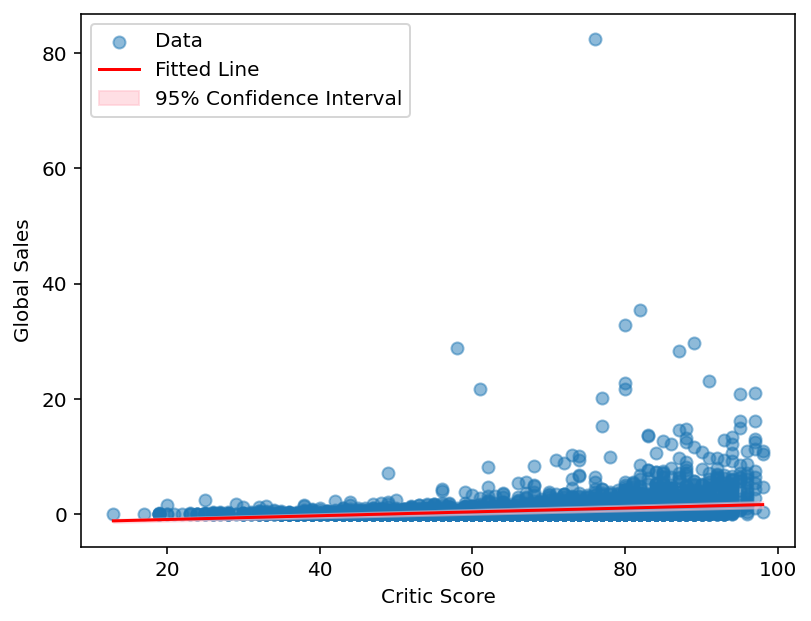

In [17]:
x = data['Critic_Score'].values
y = data['Global_Sales'].values


def linfunc(x, a, b):
    """ Function for fitting a straight line, for curve_fit
        x: independent variable
        a, b: parameters to be fitted
    """
    return a * x + b

popt, pcov = curve_fit(linfunc, x, y, p0=[1, np.mean(y)])

sigma = np.sqrt(np.diag(pcov))

# Define the range of x values for plotting the fit
xfit = np.linspace(np.min(x), np.max(x), 100)
yfit = linfunc(xfit, *popt)

pred_sigma = np.sqrt(np.diag(pcov))

t_val = t.ppf(0.975, len(x) - 2)   # t value for 95% CI and n-2 dof
ci = t_val * pred_sigma

yfit_upper = linfunc(xfit, *(popt + ci))
yfit_lower = linfunc(xfit, *(popt - ci))

plt.figure(dpi=144)
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(xfit, yfit, 'r-', label='Fitted Line')

# Plotting the error margins
plt.fill_between(xfit, yfit_lower, yfit_upper, color='pink', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Critic Score')
plt.ylabel('Global Sales')
plt.legend()
plt.show()

In [18]:

# Function to plot a histogram for Global Sales
def plot_histogram_global_sales(data):
    """
    Plot a histogram of the Global Sales data.
    
    Args:
        data (DataFrame): The cleaned data containing 'Global_Sales' column.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data['Global_Sales'].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title("Histogram of Global Sales")
    plt.xlabel('Global Sales')
    plt.ylabel('Frequency')
    plt.show()


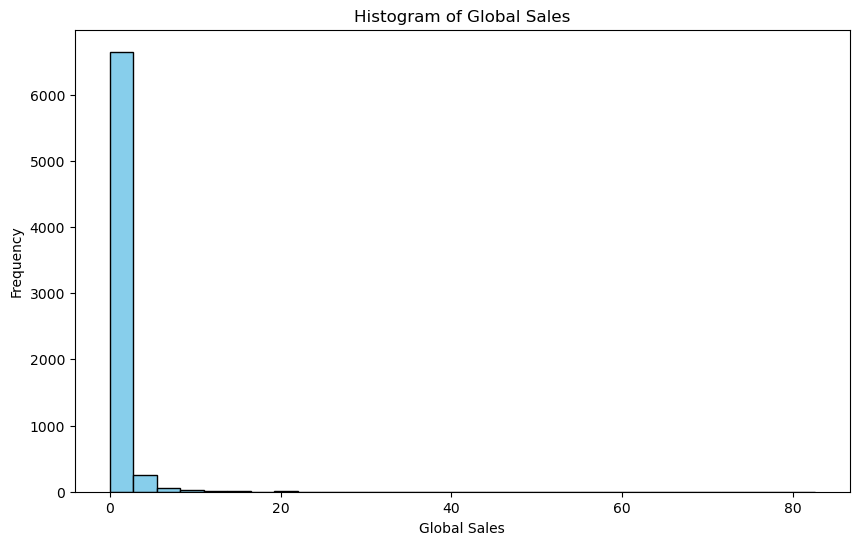

In [19]:
plot_histogram_global_sales(data)


In [20]:
# Function to plot a scatter plot for Critic Score vs Global Sales
def plot_scatter_critic_global_sales(data):
    """
    Plot a scatter plot of Critic Score against Global Sales.
    
    Args:
        data (DataFrame): The cleaned data containing 'Critic_Score' and 'Global_Sales' columns.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Critic_Score'], data['Global_Sales'], alpha=0.5)
    plt.title("Scatter Plot of Critic Score vs Global Sales")
    plt.xlabel('Critic Score')
    plt.ylabel('Global Sales')
    plt.show()



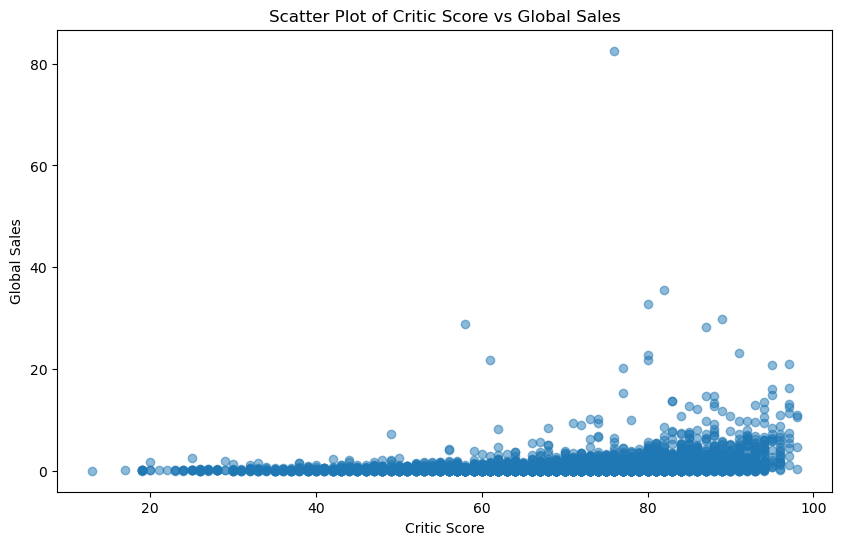

In [21]:
plot_scatter_critic_global_sales(data)


In [22]:
# Function to plot a box plot for User Score
def plot_boxplot_user_score(data):
    """
    Plot a box plot of the User Score data.
    
    Args:
        data (DataFrame): The cleaned data containing 'User_Score' column.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=data['User_Score'])
    plt.title("Box Plot of User Score")
    plt.ylabel('User Score')
    plt.show()


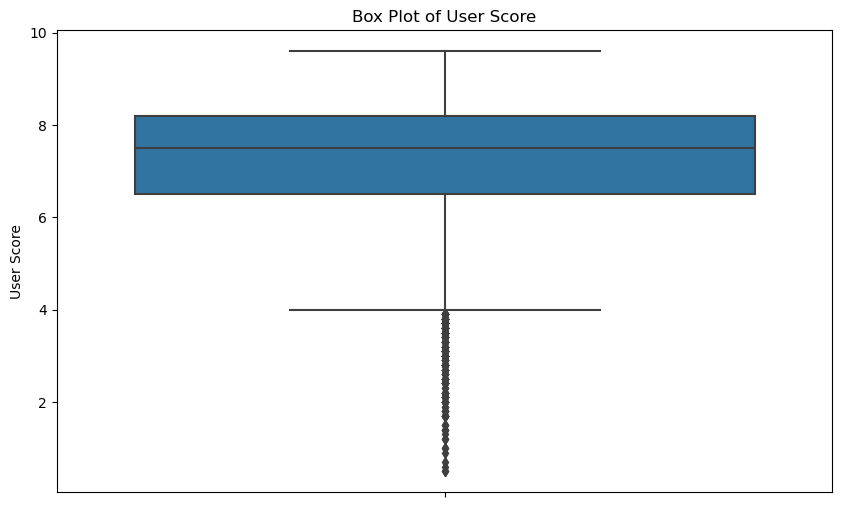

In [23]:
plot_boxplot_user_score(data)


In [28]:


# Function to generate an elbow plot using numeric data
def plot_elbow_numeric_data(data, max_clusters=10):
    """
    Generate and plot the elbow curve for the given data to find the optimal number of clusters.
    
    Args:
        data (DataFrame): The numeric data for clustering.
        max_clusters (int): The maximum number of clusters to test for.
    """
    distortions = []
    K = range(1, max_clusters+1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(data)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method showing the optimal k')
    plt.show()

C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mamao\anaconda3\Lib\site-packages\sklearn\clust

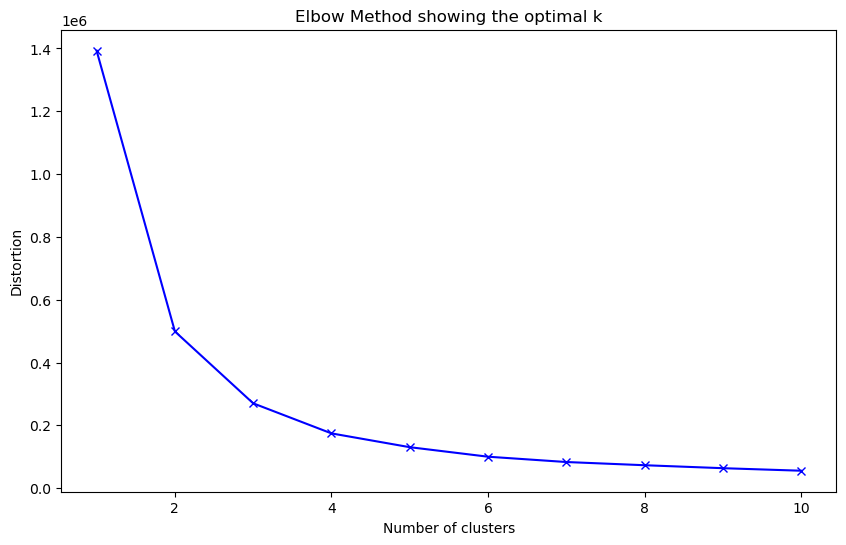

In [29]:
plot_elbow_numeric_data(data[['User_Score', 'Critic_Score', 'Global_Sales']])